#Keyword Extraction from text

* It is task of Natural Language Processing.
* Automatically identifies a **set of terms** to describe the subject of text.
* It plays a major role in information retrieval(IR) systems: keywords simplify and speed up research.
* It can also be used to reduce text dimensionality for text analysis(subject modeling text classification).
* It can be used in:
  * automatically indexing data
  * summarizing text
  * generating tag clouds with most representative keywords.

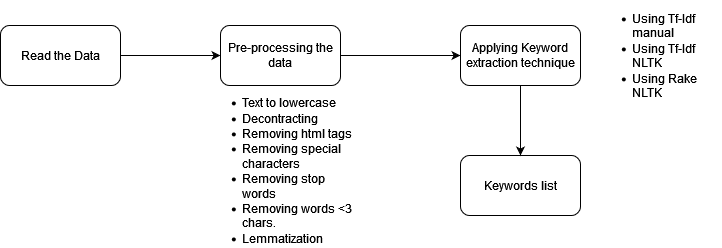

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/knight')

#from salvador import color

In [32]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from nltk.corpus import wordnet

##Reading the data

In [4]:
import json
import getpass as gt
from zipfile import ZipFile

try:
  user
except:
  user = input('Provide Kaggle Username : ')

try:
  api
except:
  api = gt.getpass('API key for '+ user +' :')

!mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
kaggle_api_key = {'username':user, 'key':api}
!chmod 600 /root/.kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json','w') as file:
  json.dump(kaggle_api_key, file)

!kaggle datasets download -d benhamner/nips-papers

print('Files present in downloaded zip :')
for names in ZipFile('/content/nips-papers.zip').namelist():
  print(names)

Provide Kaggle Username : vinodkumar9576
API key for vinodkumar9576 :··········
mkdir: cannot create directory ‘/root/.kaggle’: File exists
nips-papers.zip: Skipping, found more recently modified local copy (use --force to force download)
Files present in downloaded zip :
authors.csv
database.sqlite
paper_authors.csv
papers.csv


In [5]:
#Reading the train.csv from zipfile
with ZipFile('/content/nips-papers.zip') as compressed:
  df = pd.read_csv(compressed.open('papers.csv'))

## Preprocessing the textual data

* Diff b/w normal lemmatizer and wordnetlemmatizer

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#if you are using nltk for the first time then you probably get the
#error saying resourse not available, then use below.
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

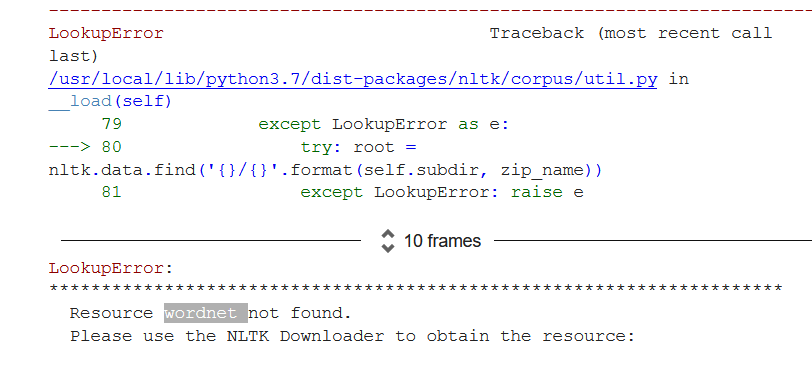

In [7]:
#Loading the stopwords for english
stop_words = set(stopwords.words('english'))

#Creating a list of custom stopwords
#below are specific to the dataset
#need to explain how to come with this list of words
new_words = ['fig', 'figure', 'image', 'sample', 'using',
             'show', 'result', 'large', 'also', 'one', 'two',
             'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

#adding custom stop words to the initial stopwords list
stop_words = list(stop_words.union(new_words))


In [8]:
# Expanding the short words
# won't to will not

import re

def decontracted(phrase):
  #specific
  phrase = re.sub(r"won\'t","will not",phrase)
  phrase = re.sub(r"can\'t","can not", phrase)

  #general
  phrase = re.sub(r"n\'t"," not", phrase)
  phrase = re.sub(r"\'re"," are",phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [9]:
#function for pre-processing(cleaning) the text
def cleaning_text(text):

  #converting the text to lowercase
  text = text.lower()

  #decontracting the sentences
  text = decontracted(text)

  #remove tags
  text = re.sub('&lt;/?.*?&gt;', ' &lt;&gt; ', text)

  #remoing special characters and digits
  text = re.sub('(\\d|\\W|_)+', ' ', text)

  #converting to list from string
  text = text.split()

  #remove stopwords
  text = [word for word in text if word not in stop_words]

  #remove words less than three letters
  text = [word for word in text if len(word) >=3]

  #lemmatize
  #lmtzr = WordNetLemmatizer()
  #text = [lmtzr.lemmatize(word) for word in text]

  #returning the cleaned text
  return ' '.join(text)

docs = df['paper_text'].apply(lambda x: cleaning_text(x))

In [10]:
def lemma_tization1(text):
  text = text.split()
  lmtzr = WordNetLemmatizer()
  text = [lmtzr.lemmatize(word) for word in text]

  return ' '.join(text)

docs1 = docs.apply(lambda x: lemma_tization1(x))

In [11]:
docs1

0       self organization associative database applica...
1       mean field theory layer visual cortex applicat...
2       storing covariance associative long term poten...
3       bayesian query construction neural network mod...
4       neural network ensemble cross validation activ...
                              ...                        
7236    single transistor learning synapsis paul hasle...
7237    bias variance combination least square estimat...
7238    real time clustering cmos neural engine serran...
7239    learning direction global motion class psychop...
7240    correlation interpolation network real time ex...
Name: paper_text, Length: 7241, dtype: object

## Using appropriate POS(parts of speech) in wordnet lemmatizer

In [12]:
def get_wordnet_pos(word_set):
  """Map POS tag to first character lemmatize() accepts"""
  pos_dict = dict()
  for word in word_set:
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    pos_dict[word] = tag_dict.get(tag, wordnet.NOUN)

  return pos_dict

In [17]:
#getting parts of speech tag for each word involved in docs so that we can save time in re-running the function if word repeats in other sentences
words_pos_dict = get_wordnet_pos(set(docs.str.cat(sep = ' ').split()))

In [18]:
def lemma_tization2(text):
  text = text.split()
  lmtzr = WordNetLemmatizer()
  text = [lmtzr.lemmatize(word, words_pos_dict.get(word)) for word in text]

  return ' '.join(text)

docs2 = docs.apply(lambda x: lemma_tization2(x))

In [19]:
docs2

0       self organization associative database applica...
1       mean field theory layer visual cortex applicat...
2       store covariance associative long term potenti...
3       bayesian query construction neural network mod...
4       neural network ensemble cross validation activ...
                              ...                        
7236    single transistor learn synapsis paul hasler c...
7237    bias variance combination least square estimat...
7238    real time cluster cmos neural engine serrano g...
7239    learn direction global motion class psychophys...
7240    correlation interpolation network real time ex...
Name: paper_text, Length: 7241, dtype: object

## Using TF-IDF technique

### Generating word count using CountVectorizer

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

#Make vocabulary of words
cv1 = CountVectorizer(max_df = 0.95,
                     max_features = 10000,
                     ngram_range = (1,3)
                     )

word_count_vector1 = cv1.fit_transform(docs1)


#Make vocabulary of words
cv2 = CountVectorizer(max_df = 0.95,
                     max_features = 10000,
                     ngram_range = (1,3)
                     )
word_count_vector2 = cv2.fit_transform(docs2)


#get feature names
#using the same countVectorizer function initialized earlier
feature_names1 = cv1.get_feature_names_out()
feature_names2 = cv2.get_feature_names_out()

In [49]:
feature_names1

array(['aaai', 'aaron', 'ab', ..., 'zone', 'zoubin', 'zoubin ghahramani'],
      dtype=object)

In [50]:
feature_names2

array(['___', 'aaai', 'aaron', ..., 'zoom', 'zoubin', 'zoubin ghahramani'],
      dtype=object)

### Calculating the reverse frequency of documents

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer1 = TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_transformer1.fit(word_count_vector1)

tfidf_transformer2 = TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_transformer2.fit(word_count_vector2)

TfidfTransformer()

### Function for keyword extraction

In [51]:
def sort_coo(coo_matrix):
  tuples = zip(coo_matrix.col, coo_matrix.data)
  return sorted(tuples, key = lambda x: (x[1], x[0]), reverse = True)

In [53]:
def extract_topn_from_vector(feature_names, sorted_items, topn = 10):
  """get the feature name and tf-idf score of topn items"""

  #use only topn items from vector
  sorted_items = sorted_items[:topn]

  score_vals = []
  feature_vals = []

  for idx, score in sorted_items:
    fname = feature_names[idx]

    #keep track of feature name and its corresponding score
    score_vals.append(round(score, 3))
    feature_vals.append(feature_names[idx])
  
  #create tuples of feature, score
  results = {}
  for idx in range(len(feature_vals)):
    results[feature_vals[idx]]=score_vals[idx]
  
  return results

In [54]:
def get_keywords(idx, docs, transformer, cv, feature_names):

  #generate tf-idf for the given document
  tf_idf_vector = transformer.transform(cv.transform([docs[idx]]))

  #sort the tf-idf vectors by descending order of scores
  sorted_items = sort_coo(tf_idf_vector.tocoo())

  #extract only the top n; n here is 10
  keywords = extract_topn_from_vector(feature_names, sorted_items, 10)

  return keywords

In [55]:
def print_results(idx, keywords, df):
  #printing the results
  print('\n=====Title=====')
  print(df['title'][idx])
  print('\n=====Abstract=====')
  print(df['abstract'][idx])
  print('\n=====Keywords=====\n')

  print(tabulate([[key, value] for key, value in keywords.items()], headers=['Keyword', 'Score'], tablefmt='orgtbl'))
  

In [56]:
#Driver code
idx = 941
keywords = get_keywords(idx, docs1, tfidf_transformer1, cv1, feature_names1)
print_results(idx, keywords, df)


=====Title=====
Algorithms for Non-negative Matrix Factorization

=====Abstract=====
Non-negative matrix factorization (NMF) has previously been shown to 
be a useful decomposition for multivariate data. Two different multi- 
plicative algorithms for NMF are analyzed. They differ only slightly in 
the multiplicative factor used in the update rules. One algorithm can be 
shown to minimize the conventional least squares error while the other 
minimizes the generalized Kullback-Leibler divergence. The monotonic 
convergence of both algorithms can be proven using an auxiliary func- 
tion analogous to that used for proving convergence of the Expectation- 
Maximization algorithm. The algorithms can also be interpreted as diag- 
onally rescaled gradient descent, where the rescaling factor is optimally 
chosen to ensure convergence. 

=====Keywords=====

| Keyword              |   Score |
|----------------------+---------|
| update rule          |   0.344 |
| update               |   0.285 |


In [57]:
idx = 941
keywords = get_keywords(idx, docs2, tfidf_transformer2, cv2, feature_names2)
print('Using Parts of speech in Lemmatization')
print_results(idx, keywords, df)

Using Parts of speech in Lemmatization

=====Title=====
Algorithms for Non-negative Matrix Factorization

=====Abstract=====
Non-negative matrix factorization (NMF) has previously been shown to 
be a useful decomposition for multivariate data. Two different multi- 
plicative algorithms for NMF are analyzed. They differ only slightly in 
the multiplicative factor used in the update rules. One algorithm can be 
shown to minimize the conventional least squares error while the other 
minimizes the generalized Kullback-Leibler divergence. The monotonic 
convergence of both algorithms can be proven using an auxiliary func- 
tion analogous to that used for proving convergence of the Expectation- 
Maximization algorithm. The algorithms can also be interpreted as diag- 
onally rescaled gradient descent, where the rescaling factor is optimally 
chosen to ensure convergence. 

=====Keywords=====

| Keyword              |   Score |
|----------------------+---------|
| update rule          |   0.33

## Using Gensim

* Simple and easy way of getting keywords from any text.

In [ ]:
from gensim.summarization import keywords

In [178]:
idx = 941
corpus = docs1
keywords_gensim = [[word] for word in keywords(corpus[idx]).split('\n')[:10]]

print('Getting keywords using gensim with corpus : docs1')
print(tabulate(keywords_gensim, headers = ['Keyword'], tablefmt='orgtbl'))

Getting keywords using gensim with corpus : docs1
| Keyword                                     |
|---------------------------------------------|
| factor                                      |
| factorizing                                 |
| approximately factorized                    |
| update rule                                 |
| convergence                                 |
| converge                                    |
| algorithm non negative matrix factorization |
| auxiliary function                          |
| theorem                                     |
| application                                 |


In [179]:
idx = 941
corpus = docs2
keywords_gensim = [[word] for word in keywords(corpus[idx]).split('\n')[:10]]

print('Getting keywords using gensim with corpus : docs2')
print(tabulate(keywords_gensim, headers = ['Keyword'], tablefmt='orgtbl'))

Getting keywords using gensim with corpus : docs2
| Keyword                                     |
|---------------------------------------------|
| factorize                                   |
| useful                                      |
| factor use update rule                      |
| convergence                                 |
| converge                                    |
| algorithm non negative matrix factorization |
| auxiliary function                          |
| theorem                                     |
| application                                 |
| optimally                                   |


## Using Tf-Idf with manual calculation

In [184]:
from nltk import tokenize
from operator import itemgetter
import math

In [230]:
idx = 941
doc = docs1[idx]
doc = doc.lower()

In [262]:
#Finding number of words in the document
total_words = doc.split()
total_words_length = len(total_words)
print(total_words_length)


#Finding number of sentences in the given doc
total_sentences = tokenize.sent_tokenize(df['paper_text'][idx])
total_sent_len = len(total_sentences)
print(total_sent_len)

1232
174


In [263]:
#Calculating Term frequency
tf_score = {}

for each_word in total_words:
  each_word = each_word.replace('.', '')
  if each_word not in stop_words:
    if each_word in tf_score:
      tf_score[each_word] += 1
    else:
      tf_score[each_word] = 1

#Dividing by total_word_length for each dictionary element
tf_score.update((x, y/int(total_words_length)) for x, y in tf_score.items())
print(tf_score)

{'algorithm': 0.013798701298701298, 'non': 0.008928571428571428, 'negative': 0.00974025974025974, 'matrix': 0.018668831168831168, 'factorization': 0.008116883116883116, 'daniel': 0.0008116883116883117, 'lee': 0.002435064935064935, 'belj': 0.0008116883116883117, 'laboratory': 0.0016233766233766235, 'lucent': 0.0008116883116883117, 'technology': 0.0016233766233766235, 'murray': 0.0008116883116883117, 'hill': 0.0008116883116883117, 'sebastian': 0.0008116883116883117, 'seung': 0.002435064935064935, 'tdept': 0.0008116883116883117, 'brain': 0.0016233766233766235, 'cog': 0.0008116883116883117, 'sci': 0.0008116883116883117, 'massachusetts': 0.0008116883116883117, 'institute': 0.0008116883116883117, 'cambridge': 0.003246753246753247, 'abstract': 0.0008116883116883117, 'nmf': 0.005681818181818182, 'previously': 0.002435064935064935, 'shown': 0.006493506493506494, 'useful': 0.005681818181818182, 'decomposition': 0.0008116883116883117, 'multivariate': 0.002435064935064935, 'data': 0.01136363636363

In [264]:
#Checking if word is present in the a sentence list
def check_sent(word, sentences):
  final = [all([w in x for w in word]) for x in sentences]
  sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
  
  return int(len(sent_len))

In [265]:
#Calculating IDF for each word
idf_score = {}

for each_word in total_words:
  each_word = each_word.replace('.', '')
  if each_word not in stop_words:
    if each_word in idf_score:
      idf_score[each_word] = check_sent(each_word, total_sentences)
    else:
      idf_score[each_word] = 1

#performing a log and divide
idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())

print(idf_score)

{'algorithm': 0.8963754221732135, 'non': 0.3799318061029996, 'negative': 0.9395475940384223, 'matrix': 1.4454832325102214, 'factorization': 1.8632184332102, 'daniel': 5.159055299214529, 'lee': 0.43166748050218845, 'belj': 5.159055299214529, 'laboratory': 1.3748656652962679, 'lucent': 5.159055299214529, 'technology': 1.0986122886681098, 'murray': 5.159055299214529, 'hill': 5.159055299214529, 'sebastian': 5.159055299214529, 'seung': 0.7770286645406473, 'tdept': 5.159055299214529, 'brain': 0.9694005571881035, 'cog': 5.159055299214529, 'sci': 5.159055299214529, 'massachusetts': 5.159055299214529, 'institute': 5.159055299214529, 'cambridge': 1.4454832325102214, 'abstract': 5.159055299214529, 'nmf': 0.7282385003712155, 'previously': 1.421385680931161, 'shown': 1.0647107369924282, 'useful': 0.752336051950276, 'decomposition': 5.159055299214529, 'multivariate': 1.0481814350412177, 'data': 0.5639354490799391, 'different': 0.7402146914179311, 'multiplicative': 1.1700712526502546, 'analyzed': 5.1

In [266]:
#Calculating TF*IDF score
tf_idf_score = {key : tf_score[key]*idf_score.get(key, 0) for key in tf_score.keys()}
print(tf_idf_score)

{'algorithm': 0.012368816702065445, 'non': 0.0033922482687767817, 'negative': 0.009151437604270346, 'matrix': 0.02698548242510965, 'factorization': 0.015123526243589284, 'daniel': 0.004187544885726079, 'lee': 0.0010511383453787055, 'belj': 0.004187544885726079, 'laboratory': 0.0022319247813251102, 'lucent': 0.004187544885726079, 'technology': 0.0017834615075781005, 'murray': 0.004187544885726079, 'hill': 0.004187544885726079, 'sebastian': 0.004187544885726079, 'seung': 0.0018921152545632646, 'tdept': 0.004187544885726079, 'brain': 0.001573702203227441, 'cog': 0.004187544885726079, 'sci': 0.004187544885726079, 'massachusetts': 0.004187544885726079, 'institute': 0.004187544885726079, 'cambridge': 0.0046931273782799396, 'abstract': 0.004187544885726079, 'nmf': 0.004137718752109179, 'previously': 0.0034611664308388658, 'shown': 0.006913706084366418, 'useful': 0.004274636658808386, 'decomposition': 0.004187544885726079, 'multivariate': 0.002552389858054913, 'data': 0.006408357375908399, 'di

In [267]:
#Function for getting top N words in the document
def get_top_n(dict_elem, n):
  result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n])
  return result

keywords = get_top_n(tf_idf_score, 10)

In [268]:
print(tabulate([[key, value] for key, value in keywords.items()], headers=['Keyword', 'Score'], tablefmt='orgtbl'))

| Keyword        |      Score |
|----------------+------------|
| matrix         | 0.0269855  |
| update         | 0.0211753  |
| auxiliary      | 0.0169222  |
| factorization  | 0.0151235  |
| function       | 0.0124124  |
| algorithm      | 0.0123688  |
| multiplicative | 0.0104471  |
| rule           | 0.00961254 |
| negative       | 0.00915144 |
| aij            | 0.00896481 |


Can be done using other various libraries like :
* spaCy
* YAKE
* Rake-NLTK